Utilizando o banco de dados “Heart Disease”:
(https://archive.ics.uci.edu/dataset/45/heart+disease) faça o que se pede a seguir.

* O conjunto de dados univariado ou multivariado? Descreva a quantidade de atributos
preditivos e atributos alvo.
* Caracterize os dados quanto ao Tipo e Escala;
* Verifique a necessidade de balanceamento dos dados e caracterize estatisticamente os dados (calcule, para cada atributo, suas estatísticas univariadas pertinentes dentre frequência, moda, média, mediana, desvio-padrão, Q1, Q3, obliquidade e curtose).
* Analise os dados quanto à sua incompletude, inconsistências, redundâncias e presença de ruído.
* Calcule estatísticas multivariadas de covariância e correlação para os atributos quantitativos presentes. Interprete os valores obtidos.
* Trace boxplots dos atributos preditivos e identifique a presença ou não de outliers.
* Plote histogramas dos atributos e interprete sua distribuição, considerando as classes.
* Promova uma transformação de dados consistente com o banco sob análise.
* Utilize a análise de componentes principais (PCA) para gerar gráficos no espaço de atributos.

In [881]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [882]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from scipy import stats
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [883]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [884]:
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [885]:
X.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
5,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0
6,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0
7,57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0
8,63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0
9,53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0


In [886]:
y.head()

,num
0,0
1,2
2,1
3,0
4,0


### a) O conjunto de dados univariado ou multivariado? Descreva a quantidade de atributos

O conjunto de dados é multivariado, já que contém múltiplas variáveis que podem ser analisadas simultaneamente.

In [887]:
print("Quantidade de atributos: " + str(len(X.columns)))

Quantidade de atributos: 13


### b) 
Caracterize os dados quanto ao tipo e escala

In [888]:
X.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
dtype: object

In [889]:
quantitative_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [890]:
print("\nValores únicos para colunas categóricas:")
for column in categorical_features:
    unique_values = X[column].unique()
    print(f"{column}: {unique_values}")


Valores únicos para colunas categóricas:
sex: [1 0]
cp: [1 4 3 2]
fbs: [1 0]
restecg: [2 0 1]
exang: [0 1]
slope: [3 2 1]
ca: [ 0.  3.  2.  1. nan]
thal: [ 6.  3.  7. nan]


In [891]:
X[categorical_features] = X[categorical_features].astype('category')

C:\Users\darth\AppData\Local\Temp\ipykernel_8204\4036185465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = X[categorical_features].astype('category')


In [892]:
X.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca          category
thal        category
dtype: object

Apesar de nos metadados anteriores, 'ca' ter vindo como numérico, escolhi transformá-lo para categórico também pelo fato dele se comportar como tal.

In [893]:
X['ca'][:10]

0    0.0
1    3.0
2    2.0
3    0.0
4    0.0
5    0.0
6    2.0
7    0.0
8    1.0
9    0.0
Name: ca, dtype: category
Categories (4, float64): [0.0, 1.0, 2.0, 3.0]

In [894]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int64   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    int64   
 4   chol      303 non-null    int64   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalach   303 non-null    int64   
 8   exang     303 non-null    category
 9   oldpeak   303 non-null    float64 
 10  slope     303 non-null    category
 11  ca        299 non-null    category
 12  thal      301 non-null    category
dtypes: category(8), float64(1), int64(4)
memory usage: 15.5 KB


### Lidando com valores nulos

Foi escolhido lidar com os valores nulos aqui para que os mesmos não atrapalhem as análises mais a frente

In [895]:
X.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

Podemos ver que as colunas 'ca' e 'thal' estão com alguns dados faltando.

In [896]:
X[X.isnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0


Quando os valores ausentes são de colunas categóricas (string ou numéricas), os valores ausentes podem ser substituídos pela categoria mais frequente. Se o número de valores ausentes for muito grande, ele poderá ser substituído por uma nova categoria, que não é nosso caso.

Porém, um algoritmo K-Nearest Neighbors (KNN) pode ser vantajoso pois ele identifica os k vizinhos mais próximos de uma instância com valor ausente e imputa um valor com base nos valores mais frequentes (moda) desses vizinhos.

Algumas vantagens do KNN a outras técnicas é que ele não é um método tão simples quanto moda, média e mediana. Ele não assume relação linear entre as variáveis como uma regressão e é menos sensível a outliers.

In [897]:
def knn_sub_null_values(data, columns, categorical=False, neighbors=5):
    df = data.copy()
    missing_info = {}
    
    for column in columns:
        missing_idx = df[df[column].isnull()].index
        
        if len(missing_idx) > 0:
            # Define o número de vizinhos com base no número de categorias únicas
            unique_values = df[column].dropna().unique()
            imputer = KNNImputer(n_neighbors=neighbors)
            df[[column]] = imputer.fit_transform(df[[column]])
            
            # Arredonda os valores para o inteiro mais próximo, já que são categorias
            if categorical == True:
                df[column] = df[column].round().astype(int)
            
                # Garante que os valores imputados estão nas categorias originais
                df[column] = df[column].apply(lambda x: x if x in unique_values else unique_values[0])
            
            missing_info[column] = list(missing_idx)
    
    for col, idx in missing_info.items():
        print(f"Valores ausentes na coluna '{col}' foram substituídos nas linhas: {idx}")
    
    return df

In [898]:
X = knn_sub_null_values(X, ['ca', 'thal'], categorical=True)

Valores ausentes na coluna 'ca' foram substituídos nas linhas: [166, 192, 287, 302]
Valores ausentes na coluna 'thal' foram substituídos nas linhas: [87, 266]


In [899]:
X.iloc[[87, 166, 192, 266, 287, 302]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0,6.0
166,52,1,3,138,223,0,0,169,0,0.0,1,1,3.0
192,43,1,4,132,247,1,2,143,1,0.1,2,1,7.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0,6.0
287,58,1,2,125,220,0,0,144,0,0.4,2,1,7.0
302,38,1,3,138,175,0,0,173,0,0.0,1,1,3.0


Podemos ver que substituímos os valores em branco dessas colunas por categorias razoáveis.

### c) Análise

Para verificar o balanceamento, vamos olhar a distribuição da variável alvo (por exemplo, target). Se a variável alvo não estiver balanceada, isso pode indicar a necessidade de balanceamento.

In [900]:
print("Contagem de cada classe da variável alvo:")
print(y.value_counts())
print("Distribuição da variável alvo:")
print(y.value_counts(normalize=True))

Contagem de cada classe da variável alvo:
num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64
Distribuição da variável alvo:
num
0      0.541254
1      0.181518
2      0.118812
3      0.115512
4      0.042904
Name: proportion, dtype: float64


Os dados se apresentam desbalanceados.

* Classe 0: Representa aproximadamente 54% dos dados, o que indica que é a classe majoritária.
* Classe 1: Representa cerca de 18% dos dados.
* Classes 2 e 3: Cada uma representa aproximadamente 11-12% dos dados.
* Classe 4: É a mais rara, com apenas 4% dos dados.

Esse desbalanceamento pode impactar modelos preditivos, pois eles tendem a favorecer a classe majoritária. Para mitigar este efeito, podemos aplicar técnicas de balanceamento, como:

* Oversampling: Replicar amostras das classes minoritárias para aumentar sua representação.
* Undersampling: Reduzir amostras da classe majoritária para equilibrar o conjunto de dados.
* Algoritmos de amostragem sintética: Como o SMOTE (Synthetic Minority Over-sampling Technique), que gera amostras sintéticas para as classes minoritárias.

Vamos agora calcular as estatísticas descritivas pertinentes para cada coluna. Para as colunas categóricas, faremos uma contagem de frequência e a moda, enquanto para as colunas numéricas calcularemos média, mediana, desvio-padrão, quartis (Q1 e Q3), obliquidade (assimetria) e curtose.

In [901]:
print("Estatísticas Univariadas para Colunas Categóricas:")

for column in categorical_features:
    data = X[column]
    
    print(f"\nColuna: {column}")
    print(f"Frequência dos valores:")
    print(data.value_counts())
    print(f"Moda: {data.mode()[0]}")


Estatísticas Univariadas para Colunas Categóricas:

Coluna: sex
Frequência dos valores:
sex
1    206
0     97
Name: count, dtype: int64
Moda: 1

Coluna: cp
Frequência dos valores:
cp
4    144
3     86
2     50
1     23
Name: count, dtype: int64
Moda: 4

Coluna: fbs
Frequência dos valores:
fbs
0    258
1     45
Name: count, dtype: int64
Moda: 0

Coluna: restecg
Frequência dos valores:
restecg
0    151
2    148
1      4
Name: count, dtype: int64
Moda: 0

Coluna: exang
Frequência dos valores:
exang
0    204
1     99
Name: count, dtype: int64
Moda: 0

Coluna: slope
Frequência dos valores:
slope
1    142
2    140
3     21
Name: count, dtype: int64
Moda: 1

Coluna: ca
Frequência dos valores:
ca
0    176
1     69
2     38
3     20
Name: count, dtype: int64
Moda: 0

Coluna: thal
Frequência dos valores:
thal
3.0    166
7.0    117
6.0     20
Name: count, dtype: int64
Moda: 3.0


In [902]:
print("Estatísticas Univariadas para Colunas Numéricas:")

for column in quantitative_features:
    data = X[column]
    
    print(f"\nColuna: {column}")
    print(f"  Média: {data.mean()}")
    print(f"  Mediana: {data.median()}")
    print(f"  Moda: {data.mode()[0]}")
    print(f"  Desvio-padrão: {data.std()}")
    print(f"  Q1 (1º Quartil): {data.quantile(0.25)}")
    print(f"  Q3 (3º Quartil): {data.quantile(0.75)}")
    print(f"  Obliquidade (Assimetria): {stats.skew(data)}")
    print(f"  Curtose: {stats.kurtosis(data)}")

Estatísticas Univariadas para Colunas Numéricas:

Coluna: age
  Média: 54.43894389438944
  Mediana: 56.0
  Moda: 58
  Desvio-padrão: 9.038662442446746
  Q1 (1º Quartil): 48.0
  Q3 (3º Quartil): 61.0
  Obliquidade (Assimetria): -0.2080240895050745
  Curtose: -0.5345227201725988

Coluna: trestbps
  Média: 131.68976897689768
  Mediana: 130.0
  Moda: 120
  Desvio-padrão: 17.59974772958769
  Q1 (1º Quartil): 120.0
  Q3 (3º Quartil): 140.0
  Obliquidade (Assimetria): 0.7025346112314821
  Curtose: 0.8458812993442368

Coluna: chol
  Média: 246.69306930693068
  Mediana: 241.0
  Moda: 197
  Desvio-padrão: 51.77691754263704
  Q1 (1º Quartil): 211.0
  Q3 (3º Quartil): 275.0
  Obliquidade (Assimetria): 1.1298741026270545
  Curtose: 4.398208250636747

Coluna: thalach
  Média: 149.6072607260726
  Mediana: 153.0
  Moda: 162
  Desvio-padrão: 22.875003276980376
  Q1 (1º Quartil): 133.5
  Q3 (3º Quartil): 166.0
  Obliquidade (Assimetria): -0.5347843657141508
  Curtose: -0.0723983595428126

Coluna: oldpea

In [903]:
mode = X.mode().iloc[0]
mode

age          58.0
sex           1.0
cp            4.0
trestbps    120.0
chol        197.0
fbs           0.0
restecg       0.0
thalach     162.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
Name: 0, dtype: float64

In [904]:
X["chol"].mode()

0    197
1    204
2    234
Name: chol, dtype: int64

In [905]:
mean = X[quantitative_features].mean()
mean

age          54.438944
trestbps    131.689769
chol        246.693069
thalach     149.607261
oldpeak       1.039604
dtype: float64

In [906]:
median = X[quantitative_features].median()
median

age          56.0
trestbps    130.0
chol        241.0
thalach     153.0
oldpeak       0.8
dtype: float64

In [907]:
std = X[quantitative_features].std()
std

age          9.038662
trestbps    17.599748
chol        51.776918
thalach     22.875003
oldpeak      1.161075
dtype: float64

In [908]:
skew = round(X[quantitative_features].skew(), 2)
skew

age        -0.21
trestbps    0.71
chol        1.14
thalach    -0.54
oldpeak     1.27
dtype: float64

In [909]:
kurt = round(X[quantitative_features].kurt(), 2)
kurt

age        -0.52
trestbps    0.88
chol        4.49
thalach    -0.05
oldpeak     1.58
dtype: float64

# Estatísticas univariadas para cada coluna
summary_stats = round(X.describe(), 2)
mode_vals = X.mode().iloc[0]
print(mode_vals)
summary_stats.loc['mode'] = mode_vals
summary_stats.loc['skew'] = X.skew()
summary_stats.loc['kurtosis'] = X.kurt()
summary_stats

### d)

Incompletude

In [910]:
missing_values = X.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_values)

Valores ausentes por coluna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


Inconsistências

In [911]:
for col in categorical_features:
    unique_values = X[col].unique()
    print(f"Valores únicos de {col}: {unique_values}")
print()
# Verificar limites razoáveis para variáveis numéricas
for col in quantitative_features:
    print(f"{col} - Min: {X[col].min()}, Max: {X[col].max()}")

Valores únicos de sex: [1, 0]
Categories (2, int64): [0, 1]
Valores únicos de cp: [1, 4, 3, 2]
Categories (4, int64): [1, 2, 3, 4]
Valores únicos de fbs: [1, 0]
Categories (2, int64): [0, 1]
Valores únicos de restecg: [2, 0, 1]
Categories (3, int64): [0, 1, 2]
Valores únicos de exang: [0, 1]
Categories (2, int64): [0, 1]
Valores únicos de slope: [3, 2, 1]
Categories (3, int64): [1, 2, 3]
Valores únicos de ca: [0 3 2 1]
Valores únicos de thal: [6. 3. 7.]

age - Min: 29, Max: 77
trestbps - Min: 94, Max: 200
chol - Min: 126, Max: 564
thalach - Min: 71, Max: 202
oldpeak - Min: 0.0, Max: 6.2


Redundâncias

In [912]:
duplicate_rows = X.duplicated().sum()
print(f"Linhas duplicadas: {duplicate_rows}")

Linhas duplicadas: 0


Presença de ruído

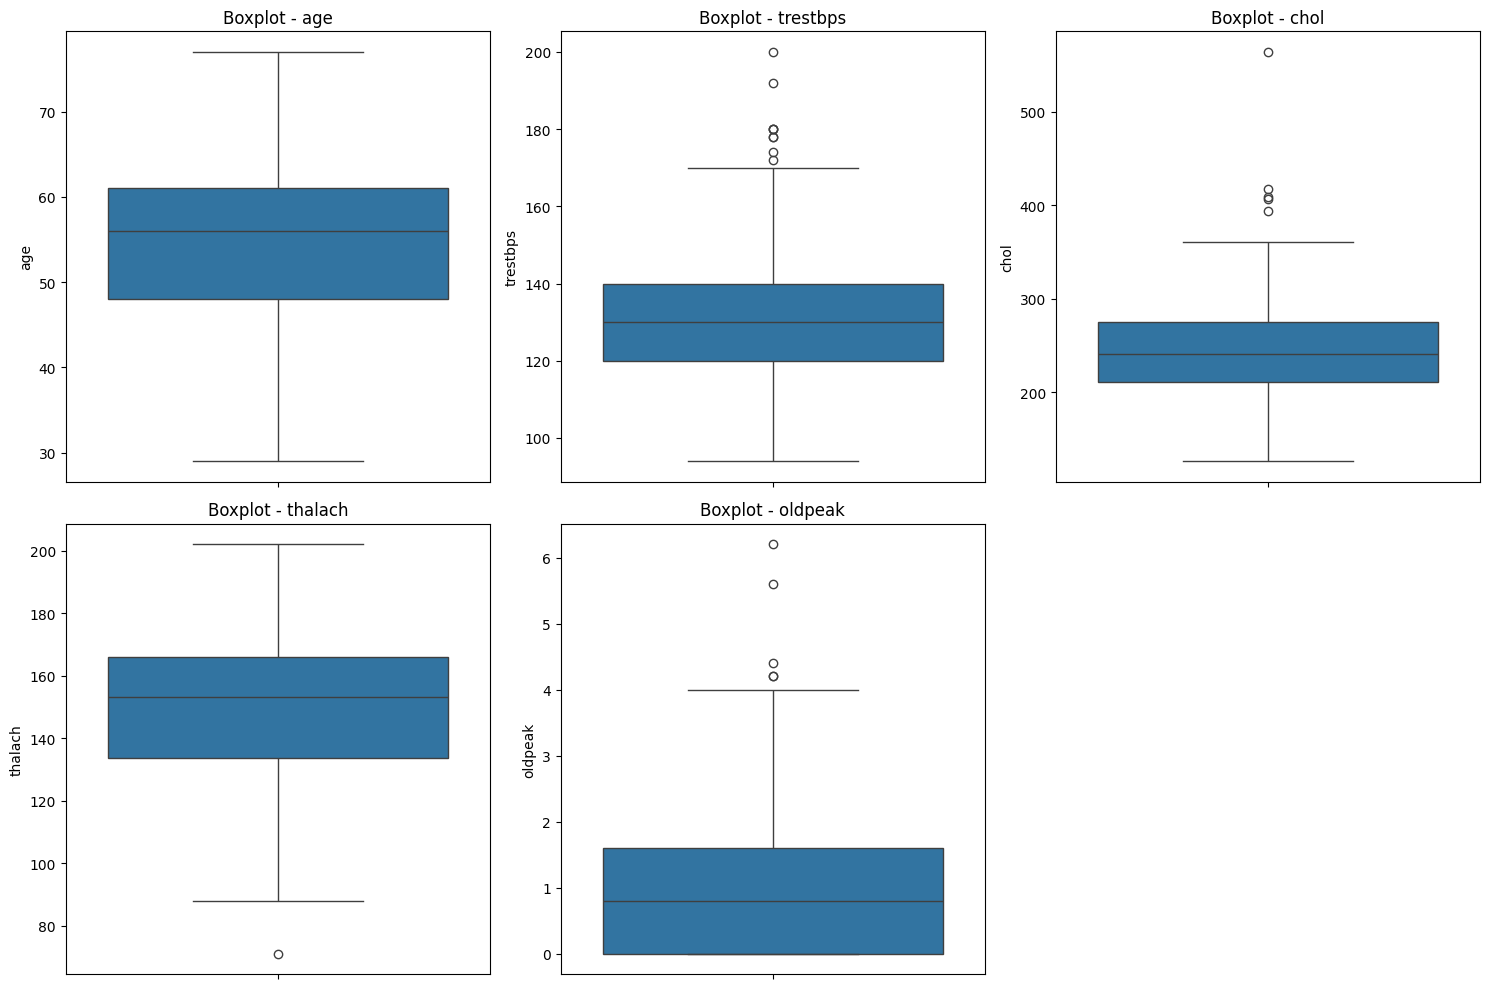

In [913]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=X[col])
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()

Agora para identificar o valor de cada um, podemos calcular o intervalo interquartil (IQR) para cada coluna. Ele é a diferença entre o terceiro quartil e o primeiro.

Definimos os limites e por fim printamos os outliers que estão acima ou abaixo dos intervalos

In [914]:
outliers = {}

for col in quantitative_features:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir limites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers[col] = X[(X[col] < lower_bound) | (X[col] > upper_bound)][col]
    
    # Exibir resumo de outliers
    print(f"Outliers em {col}:")
    print(outliers[col])
    print(f"Total de outliers em {col}: {len(outliers[col])}\n")


Outliers em age:
Series([], Name: age, dtype: int64)
Total de outliers em age: 0

Outliers em trestbps:
14     172
83     180
126    200
172    174
183    178
188    192
201    180
213    178
231    180
Name: trestbps, dtype: int64
Total de outliers em trestbps: 9

Outliers em chol:
48     417
121    407
152    564
173    394
181    409
Name: chol, dtype: int64
Total de outliers em chol: 5

Outliers em thalach:
245    71
Name: thalach, dtype: int64
Total de outliers em thalach: 1

Outliers em oldpeak:
91     6.2
123    5.6
183    4.2
191    4.2
285    4.4
Name: oldpeak, dtype: float64
Total de outliers em oldpeak: 5



* age: Não foram encontrados outliers para essa variável.
* trestbps (pressão arterial em repouso): Identificamos 9 outliers. Esses valores são significativamente maiores que os demais no dataset, indicando valores de pressão arterial muito elevados.
* chol (colesterol sérico): Foram encontrados 5 outliers, que são valores muito altos de colesterol sérico. Esses valores podem ser casos extremos de níveis de colesterol, o que pode ser normal em uma população de pacientes com histórico de doenças cardíacas.
* thalach (frequência cardíaca máxima): Apenas 1 outlier foi identificado, representando uma frequência cardíaca muito baixa em comparação com o restante dos dados.
* oldpeak (depressão do segmento ST induzida pelo exercício): Encontramos 5 outliers, todos valores muito altos, o que pode indicar casos graves de alteração do segmento ST.

### e)

**Covariância**: Valores positivos indicam que, em média, as variáveis aumentam ou diminuem juntas, enquanto valores negativos indicam que uma variável tende a diminuir quando a outra aumenta. Valores próximos de zero indicam pouca ou nenhuma variação conjunta.

**Correlação**: Valores próximos de 1 indicam uma forte correlação positiva (ambas variáveis aumentam juntas). Valores próximos de -1 indicam uma forte correlação negativa (uma variável aumenta enquanto a outra diminui). Valores próximos de 0 indicam pouca ou nenhuma correlação linear.

In [915]:
cov_matrix = X[quantitative_features].cov()
print("Matriz de covariância:\n", cov_matrix)

Matriz de covariância:
                 age    trestbps         chol     thalach   oldpeak
age       81.697419   45.328678    97.787489  -81.423065  2.138850
trestbps  45.328678  309.751120   118.573339  -18.258005  3.865638
chol      97.787489  118.573339  2680.849190   -4.064651  2.799282
thalach  -81.423065  -18.258005    -4.064651  523.265775 -9.112209
oldpeak    2.138850    3.865638     2.799282   -9.112209  1.348095


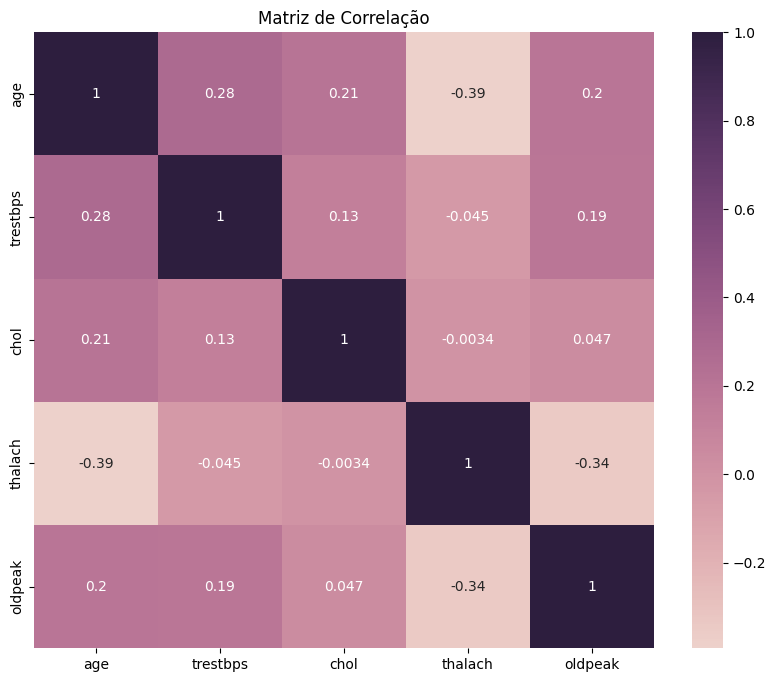

In [916]:
cov_matrix = X[quantitative_features].cov()
corr_matrix = X[quantitative_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de Correlação")
plt.show()


* Age e Thalach: A correlação negativa de -0.39 mostra uma relação inversa moderada entre idade e frequência cardíaca máxima, indicando que pessoas mais velhas tendem a ter frequências cardíacas máximas mais baixas.
* Age e Trestbps: A correlação de 0.28 sugere uma relação positiva fraca entre idade e pressão arterial em repouso.
* Oldpeak e Thalach: Com uma correlação de -0.34, isso indica que indivíduos com maior frequência cardíaca tendem a ter valores menores de oldpeak, o que é consistente com o aumento da recuperação cardíaca com maior frequência cardíaca.
* Trestbps e Chol: Com uma correlação de 0.13, a relação é positiva, mas muito fraca, sugerindo que pressão arterial em repouso e colesterol têm pouca dependência.

### f) Histograma

In [917]:
X_y = pd.concat([X, y], axis=1)
X_y.rename(columns={'num': 'y'}, inplace=True)
X_y

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,y
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1


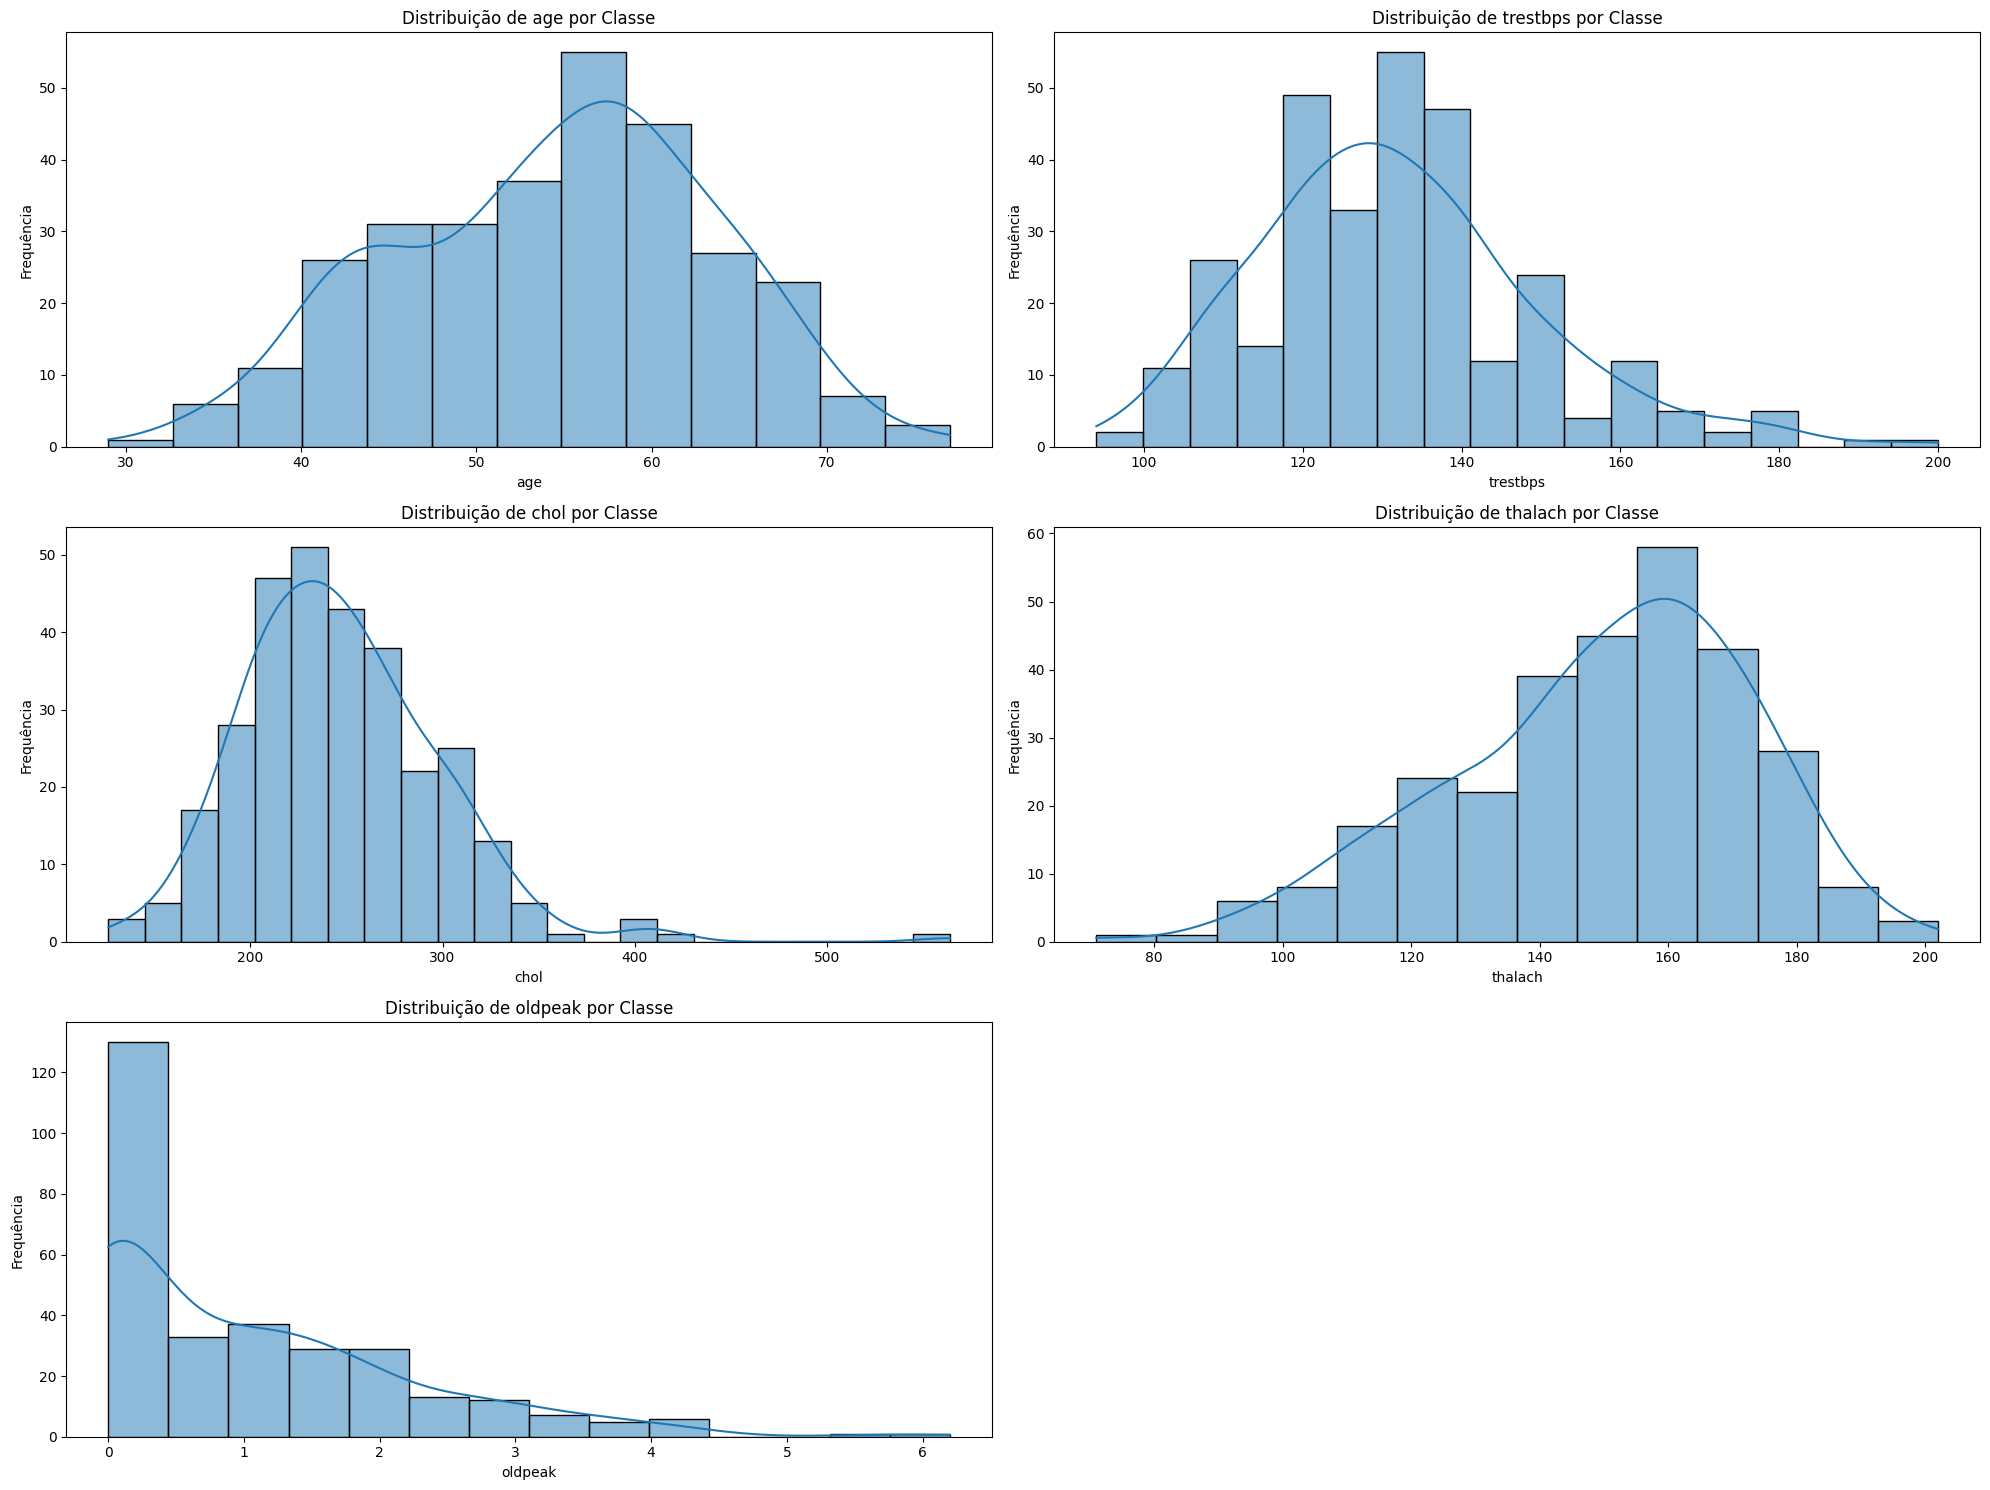

In [918]:
plt.figure(figsize=(20, 15))

# Plotando cada atributo em subplots
for i, column in enumerate(quantitative_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=X_y, x=column, kde=True, multiple='stack')
    plt.title(f'Distribuição de {column} por Classe')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

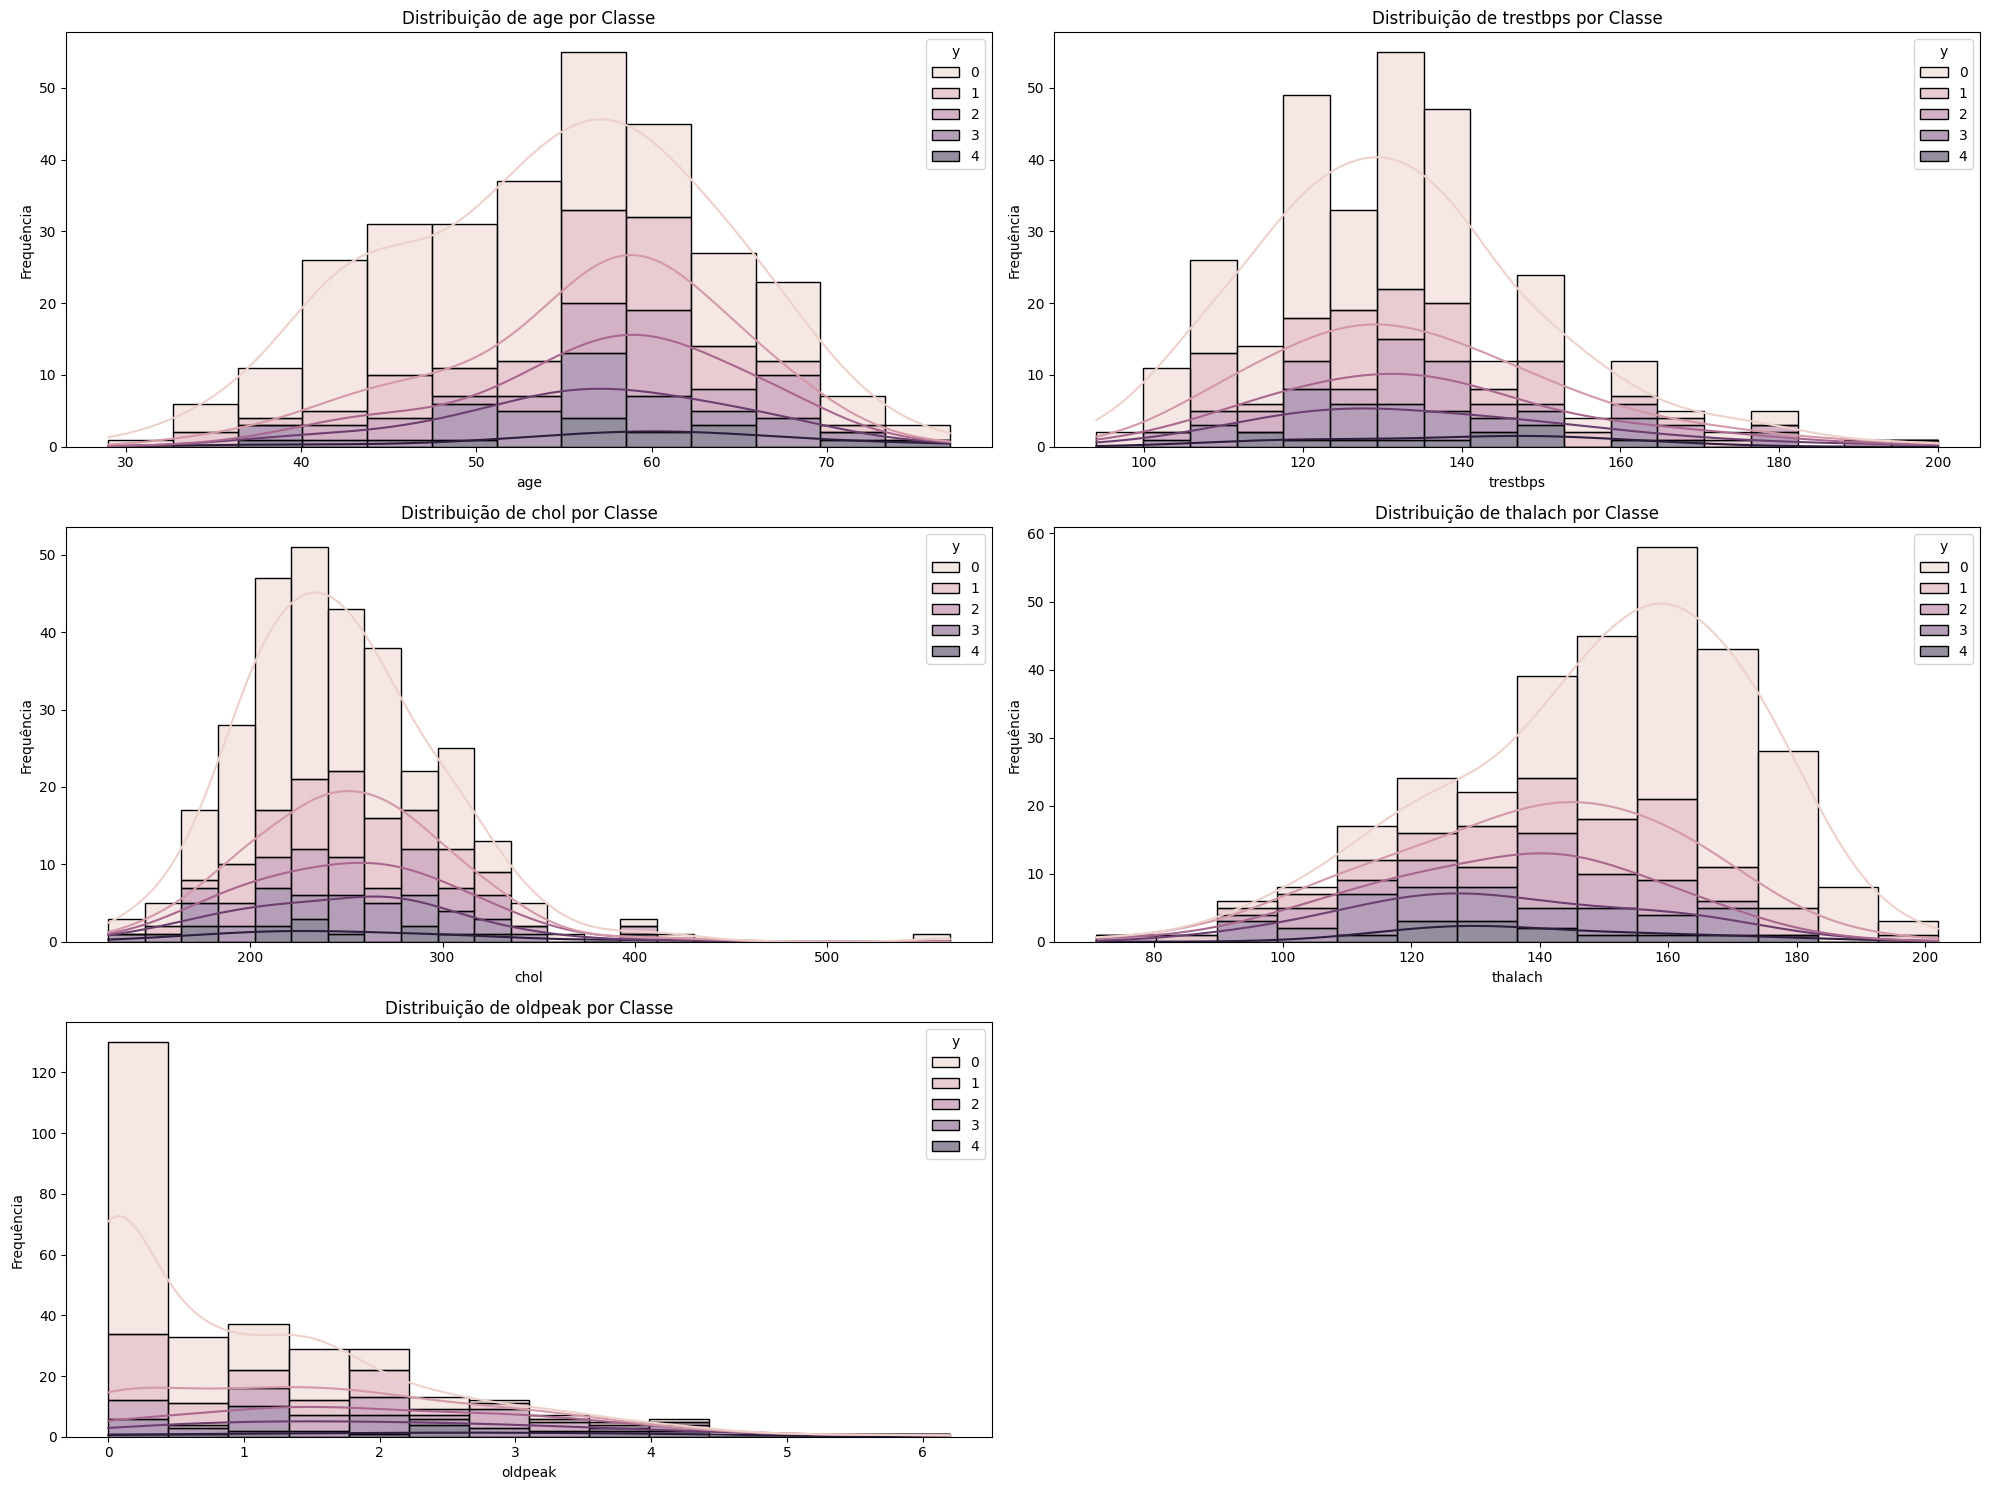

In [919]:
plt.figure(figsize=(20, 15))

# Plotando cada atributo em subplots
for i, column in enumerate(quantitative_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=X_y, x=column, hue='y', kde=True, multiple='stack')
    plt.title(f'Distribuição de {column} por Classe')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

- **Age (Idade):**
    
    A idade apresenta uma distribuição próxima da normal, com um leve viés para a direita. A maioria das classes de doença cardíaca apresenta picos em faixas etárias semelhantes, mas é possível notar uma leve concentração de casos com maior gravidade em faixas etárias mais avançadas.

- **Trestbps (Pressão Arterial em Repouso):**

    A pressão arterial em repouso parece ter uma distribuição levemente assimétrica à direita.
    
    As classes são relativamente sobrepostas, mas a classe 0 (sem doença) tem valores ligeiramente mais baixos em média.

- **Chol (Colesterol):**
    
    O colesterol tem uma distribuição ampla, com uma cauda à direita, indicando alguns casos com níveis de colesterol muito altos.
    
    Não há uma diferença clara nas distribuições entre as classes, sugerindo que o colesterol elevado pode estar presente independentemente da gravidade da doença.

- **Thalach (Frequência Cardíaca Máxima):**

    As classes de maior gravidade de doença cardíaca parecem ser a 0 parecem ter valores mais baixos de frequência cardíaca máxima, o que pode indicar um comprometimento na capacidade cardiovascular.

- **Oldpeak (Depressão do Segmento ST):**
    
    A distribuição de oldpeak é altamente assimétrica, com a maioria dos valores próximos de zero.
    
    As classes de maior gravidade apresentam valores maiores de oldpeak, indicando um nível maior de depressão do segmento ST, um indicativo potencial de isquemia.

### Transformações

Antes de aplicar PCA, é importante escalar os dados, especialmente se os atributos têm escalas diferentes.


In [920]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[quantitative_features])

### PCA


A PCA é uma ferramenta valiosa para a visualização de dados e pode ajudar na identificação de padrões e separações entre classes em conjuntos de dados de alta dimensionalidade. As visualizações geradas oferecem uma maneira clara de entender como os dados se comportam em um espaço reduzido, facilitando a análise e a interpretação dos resultados.

In [921]:
pca = PCA(n_components=3)  # Reduzindo para 2 componentes principais

X_pca = pca.fit_transform(X_scaled)

# Criando um DataFrame para os componentes principais
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['y'] = y.reset_index(drop=True)


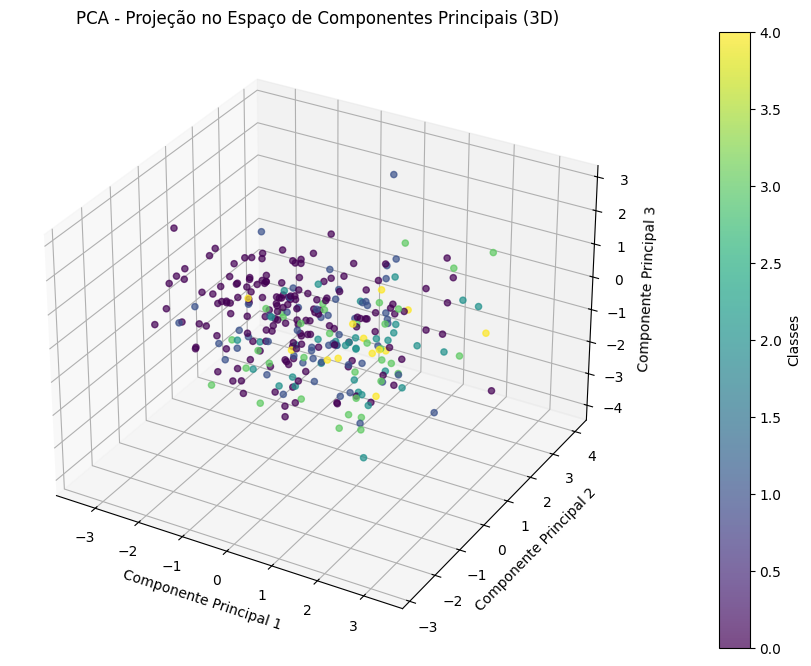

In [922]:
# Criando um gráfico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotando os pontos no espaço 3D
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['y'], cmap='viridis', alpha=0.7)

# Adicionando título e rótulos
ax.set_title('PCA - Projeção no Espaço de Componentes Principais (3D)')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')

# Adicionando uma barra de cores
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Classes')

plt.show()
